In [1]:
# Data Loading and Exploring
import pandas as pd
import numpy as np
from pathlib import Path
from sodapy import Socrata

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px

# Data Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from sklearn.model_selection import GridSearchCV
import joblib
import tensorflow as tf


# Performance Measurement Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Custom Modules
from utils.data_loader import load_crime_dataset
from utils.maps import ChicagoMap

# Filter out Warnings
import warnings
warnings.filterwarnings("ignore")

# Visualization Configuration
sns.set_theme(style="ticks", color_codes=True)


In [2]:
# Location of stored dataset
dataset_path = Path('../datasets/chicago-crime-data.csv')

if dataset_path.exists():
    print(f"File found: {dataset_path.name}")
else:
    load_crime_dataset()

File found: chicago-crime-data.csv


In [3]:
crime_df = pd.read_csv(dataset_path)
crime_df['date'] = pd.to_datetime(crime_df['date'])

##### Data Preprocessing

In [4]:
def preprocess_crime_data(crime_df):
    # Step 1: Drop redundant columns
    crime_df.drop(columns=crime_df.columns[22:], axis=1, inplace=True)
    print("Dataset Shape:",crime_df.shape)
    
    # Step 2: Detect and drop duplicates
    print(f"Duplicated rows detected: {sum(crime_df.duplicated())}")
    crime_df.drop_duplicates(inplace=True)
    
    # Step 3: Check and handle missing values
    print(f"Missing Values: {sum(crime_df.isna().sum())}")
    crime_df.dropna(inplace=True)
    
    # Step 4: Compute arrest rate and create encoding_dict
    encoding_dict = {
        primary_type: idx
        for idx, (primary_type, _) in enumerate(
            crime_df.groupby('primary_type')
            .apply(lambda g: ((g['arrest'].sum() / len(g)) * 100).round(2))
            .sort_values()
            .items()
        )
    }
    
    # Step 5: Encode 'primary_type' and update 'arrest' column
    crime_df['primary_type_encoded'] = crime_df['primary_type'].map(encoding_dict).fillna(-1).astype(int)
    crime_df['arrest'] = crime_df['arrest'].astype(int)
    
    # Step 6: Feature selection
    features = ['domestic', 'district', 'beat', 'community_area', 'ward',
                'x_coordinate', 'y_coordinate', 'latitude', 'longitude',
                'year', 'primary_type_encoded']
    target = 'arrest'
    
    X = crime_df[features]
    Y = crime_df[target]
    
    # Step 7: Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, Y

##### Model Training and Tuning

In [5]:
def train_and_evaluate_neural_network():
    # Separate the classes
    arrest_true = crime_df[crime_df['arrest'] == True]
    arrest_false = crime_df[crime_df['arrest'] == False]

    # Sample rows from each class
    arrest_true_sample = arrest_true.sample(n=200000, random_state=42)
    arrest_false_sample = arrest_false.sample(n=500000, random_state=42)

    # Combine the samples into one DataFrame
    balanced_df = pd.concat([arrest_true_sample, arrest_false_sample])

    # Shuffle the resulting DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    X, Y = preprocess_crime_data(balanced_df)

    # Step 1: Split the data into training and testing sets
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
    print("Data split complete. Training set size:", X_train.shape, "Test set size:", X_test.shape)

    # Step 2: Normalize the features
    print("Normalizing features...")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    print("Normalization complete.")

    # Step 3: Define the TensorFlow neural network model
    print("Defining the TensorFlow model...")
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(Y)), activation='softmax')  # Adjust output layer for class count
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Step 4: Train the model
    print("Training the model...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
    print("Model training complete.")

    # Step 5: Evaluate the model on the test set
    print("Evaluating the model on the test set...")
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Step 6: Create confusion matrix and display it using seaborn
    print("Generating confusion matrix...")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title("Confusion Matrix")
    heatmap_path = Path('../model-reports/nuralnetwork_confusion_matrix.png')
    plt.savefig(heatmap_path)
    plt.show()
    print(f"Confusion matrix heatmap saved as '{heatmap_path}'.")

    # Step 7: Generate classification report and accuracy score
    print("Generating classification report and accuracy score...")
    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Neural Network Classification Report:")
    print(report)
    print("Accuracy:", accuracy)

    # Save classification report and accuracy to a text file
    report_path = Path('../model-reports/nuralnetwork_report.txt')
    with open(report_path, "w") as f:
        f.write("Neural Network Classification Report:\n")
        f.write(report)
        f.write("\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
    print(f"Classification report saved as '{report_path}'.")

    # Step 8: Save the trained model
    print("Saving the model...")
    model.save(Path('../model-reports/neural_network_model.keras'))
    print("Model saved as 'neural_network_model.keras'")


In [6]:
def train_and_evaluate_random_forest(df):
    X, Y = preprocess_crime_data(df)
    
    # Step 1: Split the data into training and testing sets
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
    print("Data split complete. Training set size:", X_train.shape, "Test set size:", X_test.shape)

    # Step 2: Define Random Forest model with specified parameters
    print("Defining the Random Forest model with custom parameters...")
    rf_model = RandomForestClassifier(
        bootstrap=True,
        max_depth=80,
        max_leaf_nodes=20,
        n_estimators=500,
        random_state=42
    )

    # Step 3: Create the pipeline with SMOTE for balancing class and Random Forest for classification
    print("Creating the pipeline with SMOTE and Random Forest...")
    smote = SMOTE(random_state=42)
    pipeline = imPipeline(steps=[
        ('smote', smote),
        ('rf_model', rf_model)
    ])

    # Step 4: Fit the model with the training data
    print("Fitting the model with training data...")
    pipeline.fit(X_train, y_train)
    print("Model training complete.")

    # Step 5: Predict on test data
    print("Making predictions on the test set...")
    rf_preds = pipeline.predict(X_test)

    # Step 6: Create confusion matrix and display it using seaborn
    print("Generating confusion matrix...")
    cm = confusion_matrix(y_test, rf_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
    plt.title("Confusion Matrix")
    heatmap_path = Path('../model-reports/nuralnetwork_confusion_matrix.png')
    plt.savefig(heatmap_path)
    plt.show()
    print(f"Confusion matrix heatmap saved as '{heatmap_path}'.")

    # Step 7: Print classification report and accuracy
    print("Generating classification report and accuracy score...")
    report = classification_report(y_test, rf_preds)
    accuracy = accuracy_score(y_test, rf_preds)
    print("Random Forest Classification Report:")
    print(report)
    print("Accuracy:", accuracy)

    # Save classification report to a text file
    report_path = Path('../model-reports/rf_report.txt')
    with open(report_path, "w") as f:
        f.write("Random Forest Classification Report:\n")
        f.write(report)
        f.write("\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
    print(f"Classification report saved as '{report_path}'.")

    # Step 8: Save the trained model as a .pkl file
    print("Saving the model as a .pkl file...")
    model_path = Path('../model-reports/random_forest_model.pkl')
    joblib.dump(pipeline, model_path)
    print(f"Model saved as '{model_path}'.")

##### Report
**Caution**: Executing below cells will initiate model training which may take a long time

Dataset Shape: (700000, 22)
Duplicated rows detected: 0
Missing Values: 50977
Splitting data into training and testing sets...
Data split complete. Training set size: (481606, 11) Test set size: (206403, 11)
Normalizing features...
Normalization complete.
Defining the TensorFlow model...
Training the model...
Epoch 1/10
12041/12041 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.8133 - loss: 0.4346 - val_accuracy: 0.8164 - val_loss: 0.4303
Epoch 2/10
12041/12041 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8182 - loss: 0.4260 - val_accuracy: 0.8174 - val_loss: 0.4285
Epoch 3/10
12041/12041 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8182 - loss: 0.4254 - val_accuracy: 0.8159 - val_loss: 0.4284
Epoch 4/10
12041/12041 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8180 - loss: 0.4247 - val_accuracy: 0.8171 - val_loss: 0.4265
Epoch 5/10
12041/12041 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.8194 - loss: 0.4217 - val_accuracy: 0.8163 - val_loss: 0.4267
Epoch 6/10
12041/12041 ━

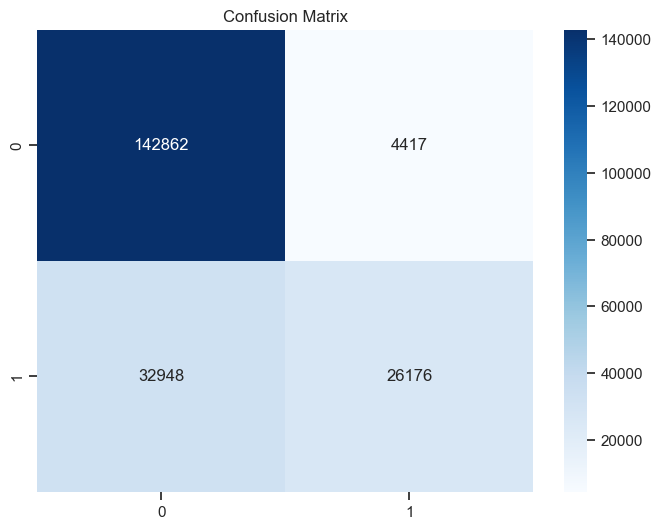

Confusion matrix heatmap saved as '..\model-reports\nuralnetwork_confusion_matrix.png'.
Generating classification report and accuracy score...
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88    147279
           1       0.86      0.44      0.58     59124

    accuracy                           0.82    206403
   macro avg       0.83      0.71      0.73    206403
weighted avg       0.82      0.82      0.80    206403

Accuracy: 0.8189706544963009
Classification report saved as '..\model-reports\nuralnetwork_report.txt'.
Saving the model...
Model saved as 'neural_network_model.keras'


In [ ]:
train_and_evaluate_neural_network()

Dataset Shape: (1408934, 22)
Duplicated rows detected: 0
Missing Values: 102057
Splitting data into training and testing sets...
Data split complete. Training set size: (969004, 11) Test set size: (415288, 11)
Defining the Random Forest model with custom parameters...
Creating the pipeline with SMOTE and Random Forest...
Fitting the model with training data...
Model training complete.
Making predictions on the test set...
Generating confusion matrix...


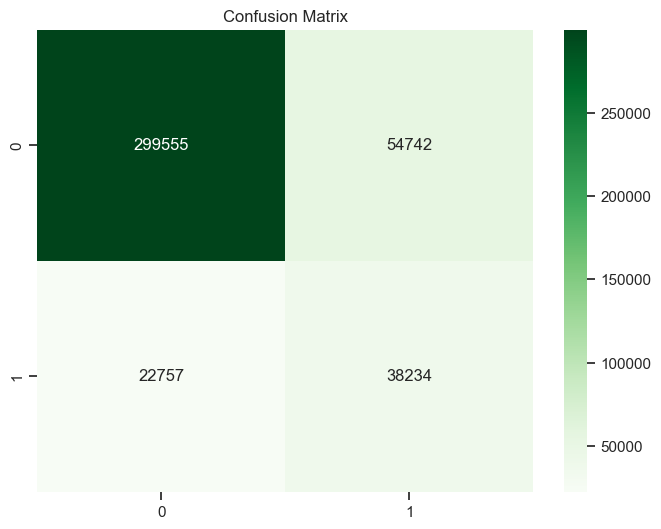

Confusion matrix heatmap saved as '..\model-reports\nuralnetwork_confusion_matrix.png'.
Generating classification report and accuracy score...
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89    354297
           1       0.41      0.63      0.50     60991

    accuracy                           0.81    415288
   macro avg       0.67      0.74      0.69    415288
weighted avg       0.85      0.81      0.83    415288

Accuracy: 0.8133849280499316
Classification report saved as '..\model-reports\rf_report.txt'.
Saving the model as a .pkl file...
Model saved as '..\model-reports\random_forest_model.pkl'.


In [ ]:
train_and_evaluate_random_forest(crime_df)